In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import json
import os
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cairosvg
from PIL import Image
import albumentations as A
import cv2
import tensorflow as tf

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Динамічне виділення пам'яті
    except RuntimeError as e:
        print(e)

In [11]:
with open("../configs/config.json", "r") as file:
    config = json.load(file)

# Виведення конфігурації
print(config)

{'data': {'raw_path': '../data/raw/svg', 'png_path': '../data/precessed/png_images', 'precessed_train_path': '../data/tfrec/train/', 'precessed_valid_path': '../data/tfrec/val/', 'class_names': ['airplane', 'alarm clock', 'angel', 'ant', 'apple', 'arm', 'armchair', 'ashtray', 'axe', 'backpack', 'banana', 'barn', 'baseball bat', 'basket', 'bathtub', 'bear (animal)', 'bed', 'bee', 'beer-mug', 'bell', 'bench', 'bicycle', 'binoculars', 'blimp', 'book', 'bookshelf', 'boomerang', 'bottle opener', 'bowl', 'brain', 'bread', 'bridge', 'bulldozer', 'bus', 'bush', 'butterfly', 'cabinet', 'cactus', 'cake', 'calculator', 'camel', 'camera', 'candle', 'cannon', 'canoe', 'car (sedan)', 'carrot', 'castle', 'cat', 'cell phone', 'chair', 'chandelier', 'church', 'cigarette', 'cloud', 'comb', 'computer monitor', 'computer-mouse', 'couch', 'cow', 'crab', 'crane (machine)', 'crocodile', 'crown', 'cup', 'diamond', 'dog', 'dolphin', 'donut', 'door', 'door handle', 'dragon', 'duck', 'ear', 'elephant', 'envelope

In [12]:
# Constants
IMAGE_SIZE = (config['model']['input_size'], config['model']['input_size'])
img_size = config['model']['input_size']
BATCH_SIZE = config['model']['batch_size']
NUM_CLASSES = config['model']['output_size']
PNG_DIR = config['data']['png_path']
TFREC_TRAIN_DIR = config['data']['precessed_train_path']
TFREC_VALID_DIR = config['data']['precessed_valid_path']
MODEL_FINAL_DIR = config['training']['final_model_dir']
MODEL_CHECK_DIR = config['training']['checkpoint_dir']
class_names = sorted(os.listdir(PNG_DIR))

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


# Функція для парсингу TFRecord
def parse_tfrecord_onehot(example_proto, num_classes):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([num_classes], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)  # Декодуємо JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Конвертуємо в float32
    label = example['label']
    return image, label

# Завантажуємо TFRecord файли
def load_tfrecord_onehot_dataset(tfrecord_files, num_classes, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(lambda x: parse_tfrecord_onehot(x, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def augment_image(image):
    # Випадкове горизонтальне віддзеркалення
    image = tf.image.random_flip_left_right(image)

    return image

# Функція для застосування аугментації під час завантаження даних
def augment_image_during_training(image, label):
    image = augment_image(image)
    return image, label


# Завантажуємо тренувальний датасет
train_tfrecord_files = [os.path.join(TFREC_TRAIN_DIR, f) for f in os.listdir(TFREC_TRAIN_DIR) if f.endswith('.tfrecord')]
train_dataset = load_tfrecord_onehot_dataset(train_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Застосовуємо аугментацію до тренувального датасету
train_dataset = train_dataset.map(
    augment_image_during_training,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Додаємо батчування та prefetch для оптимізації
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість тренувальних зразків
total_train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_files))


# Завантажуємо валідаційний датасет
val_tfrecord_files = [os.path.join(TFREC_VALID_DIR, f) for f in os.listdir(TFREC_VALID_DIR) if f.endswith('.tfrecord')]
val_dataset = load_tfrecord_onehot_dataset(val_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Додаємо батчування та prefetch для валідаційного датасету
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість валідаційних зразків
total_val_samples = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_files))

steps_per_epoch = (total_train_samples + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (total_val_samples + BATCH_SIZE - 1) // BATCH_SIZE




2025-01-19 14:08:10.009725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


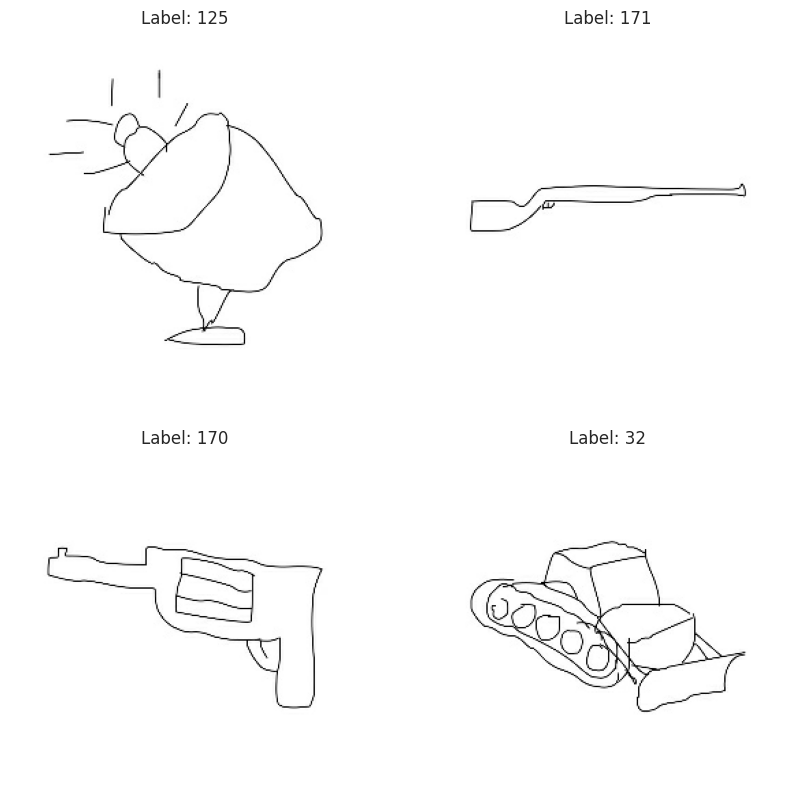

In [14]:
def visualize_images(dataset, num_images=4, is_onehot=False):
    # Беремо один батч з даними
    for images, labels in dataset.take(1):
        images = images.numpy()  # Конвертуємо тензори в NumPy
        labels = labels.numpy()

        # Перевіряємо, чи є дані в батчі
        batch_size = images.shape[0]
        if batch_size == 0:
            raise ValueError("Батч порожній, перевірте ваш датасет.")
        
        # Візуалізуємо тільки до num_images зображень
        num_images = min(num_images, batch_size)

        # Створюємо сітку для візуалізації
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(2, 2, i + 1)
            
            # Отримуємо одне зображення
            image = images[i]

            # Відображення залежно від діапазону значень
            if image.max() > 1.0:
                plt.imshow(image.astype('uint8'))
            else:
                plt.imshow(image)
            
            # Отримуємо мітку
            if is_onehot:
                label = np.argmax(labels[i])
            else:
                label = labels[i]
            
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

# Виклик функції з урахуванням батчів
visualize_images(train_dataset, is_onehot=True)


In [15]:
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Функція для створення моделі

model_name = "MobileNetV2"
EPOCHS = 10
LAYERS_TO_UNFREEZE1 = 6 # Кількість шарів, які не тренуватимуться
LAYERS_TO_UNFREEZE2 = 12  # Кількість шарів, які не тренуватимуться


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # 1024 for MobileNetV2, for VGG19 needed like 4096
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # num_classes should match your dataset

model = Model(inputs=base_model.input, outputs=predictions)

/tmp/ipykernel_72094/3477281791.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))


In [16]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(MODEL_CHECK_DIR + model_name + 'base.keras', monitor='val_accuracy', save_best_only=True)
]

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage_1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps 
)

Epoch 1/10


2025-01-19 14:08:17.570676: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4773', 36 bytes spill stores, 36 bytes spill loads

E0000 00:00:1737295699.080853   72389 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737295699.216286   72389 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 997/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0732 - loss: 5.2444

2025-01-19 14:08:44.713783: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4773', 44 bytes spill stores, 44 bytes spill loads

E0000 00:00:1737295726.052522   72388 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737295726.189355   72388 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737295726.322481   72388 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737295726.458498   72388 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please inve

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0735 - loss: 5.2418

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.0735 - loss: 5.2409 - val_accuracy: 0.4123 - val_loss: 2.6587 - learning_rate: 1.0000e-04
Epoch 2/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3681 - loss: 2.8173

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.3682 - loss: 2.8170 - val_accuracy: 0.5157 - val_loss: 2.0801 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4930 - loss: 2.1304

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.4930 - loss: 2.1303 - val_accuracy: 0.5608 - val_loss: 1.8203 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5687 - loss: 1.7540

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5687 - loss: 1.7540 - val_accuracy: 0.5935 - val_loss: 1.6928 - learning_rate: 1.0000e-04
Epoch 5/10
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6205 - loss: 1.5264

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6205 - loss: 1.5263 - val_accuracy: 0.6022 - val_loss: 1.6138 - learning_rate: 1.0000e-04
Epoch 6/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6633 - loss: 1.3305

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.6633 - loss: 1.3305 - val_accuracy: 0.6137 - val_loss: 1.5615 - learning_rate: 1.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6999 - loss: 1.1741

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6999 - loss: 1.1741 - val_accuracy: 0.6170 - val_loss: 1.5335 - learning_rate: 1.0000e-04
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7276 - loss: 1.0489

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7275 - loss: 1.0489 - val_accuracy: 0.6215 - val_loss: 1.5103 - learning_rate: 1.0000e-04
Epoch 9/10
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7497 - loss: 0.9482

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7497 - loss: 0.9482 - val_accuracy: 0.6217 - val_loss: 1.4982 - learning_rate: 1.0000e-04
Epoch 10/10
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7770 - loss: 0.8525

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.7770 - loss: 0.8525 - val_accuracy: 0.6240 - val_loss: 1.4892 - learning_rate: 1.0000e-04


In [17]:
for layer in model.layers[-LAYERS_TO_UNFREEZE1:]: 
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8065 - loss: 0.7317

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.8065 - loss: 0.7317 - val_accuracy: 0.6350 - val_loss: 1.4476 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8291 - loss: 0.6811

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.8291 - loss: 0.6810 - val_accuracy: 0.6367 - val_loss: 1.4386 - learning_rate: 1.0000e-05
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8338 - loss: 0.6451

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8338 - loss: 0.6450 - val_accuracy: 0.6375 - val_loss: 1.4355 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8406 - loss: 0.6211 - val_accuracy: 0.6375 - val_loss: 1.4358 - learning_rate: 1.0000e-05
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8464 - loss: 0.5943

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8464 - loss: 0.5943 - val_accuracy: 0.6407 - val_loss: 1.4338 - learning_rate: 1.0000e-05
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8528 - loss: 0.5815 - val_accuracy: 0.6407 - val_loss: 1.4307 - learning_rate: 1.0000e-05
Epoch 7/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8547 - loss: 0.5777

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8547 - loss: 0.5776 - val_accuracy: 0.6413 - val_loss: 1.4304 - learning_rate: 1.0000e-05
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8561 - loss: 0.5624 - val_accuracy: 0.6398 - val_loss: 1.4298 - learning_rate: 1.0000e-05
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8558 - loss: 0.5650 - val_accuracy: 0.6392 - val_loss: 1.4320 - learning_rate: 1.0000e-05
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8695 - loss: 0.5357 - val_accuracy: 0.6410 - val_loss: 1.4319 - learning_rate: 1.0000e-05


In [18]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint(MODEL_CHECK_DIR + model_name + 'fine.keras', monitor='val_accuracy', save_best_only=True)
]

for layer in model.layers[-LAYERS_TO_UNFREEZE2:]:  # Unfreeze last 6 layers
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5488 - loss: 1.7835 - val_accuracy: 0.6000 - val_loss: 1.6125 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.6641 - loss: 1.2816 - val_accuracy: 0.6087 - val_loss: 1.5752 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7115 - loss: 1.0889 - val_accuracy: 0.6180 - val_loss: 1.5590 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7372 - loss: 0.9788 - val_accuracy: 0.6187 - val_loss: 1.5366 - learning_rate: 1.0000e-05
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7511 - loss: 0.9038 - val_accuracy: 0.6233 - val_loss: 1.5282 - learning_rate: 1.0000e-05
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.7684 - loss: 0.8458 - val_accuracy: 0.6288 - val_loss: 1.5111 - learning_rate: 1.0000e-05
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [20]:
# Збереження моделі
model.save(MODEL_FINAL_DIR + model_name + '.keras')
